In [39]:
from langchain_groq import ChatGroq
import os

groq_api_key = os.getenv('GROQ_API_KEY')

llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")

In [40]:
llm.invoke("hi").content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [41]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated, Literal
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [42]:
def call_model(state: MessagesState):
    question = state['messages']
    response = llm.invoke(question).content
    return {"messages": [response]}

In [43]:
workflow = StateGraph(MessagesState)

workflow.add_node("chatbot" ,call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", END)

app = workflow.compile()

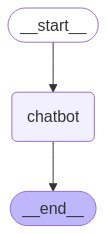

In [44]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [45]:
input = {"messages": ["who won the first cricket worldcup"]}
app.invoke(input)

{'messages': [HumanMessage(content='who won the first cricket worldcup', additional_kwargs={}, response_metadata={}, id='d3f0935a-75f9-41e8-9b6b-2aaddaaf1e25'),
  HumanMessage(content="The first Cricket World Cup was held in 1975 in England. The West Indies cricket team, led by Clive Lloyd, won the tournament by defeating Australia in the final at Lord's Cricket Ground on June 21, 1975. The West Indies won by 17 runs, with a score of 291/8 in 60 overs, while Australia was bowled out for 274 in 58.4 overs.", additional_kwargs={}, response_metadata={}, id='91260586-f410-4aab-aa31-31c9ff22db70')]}

In [46]:
response = app.invoke(input)

In [47]:
response['messages'][-1].content

"The first Cricket World Cup was held in 1975 in England, and it was won by the West Indies. They defeated Australia in the final at Lord's Cricket Ground on June 21, 1975, by 17 runs. The West Indies team, led by Clive Lloyd, scored 291/8 in 60 overs, and Australia was bowled out for 274 in 58.4 overs."

In [48]:
for output in app.stream(input):
    for key, value in output.items():
        print(f"Output from '{key}' Node")
        print("_____")
        print(value)
        print("\n")

Output from 'chatbot' Node
_____
{'messages': ["The first Cricket World Cup was held in 1975 in England. The West Indies cricket team, led by Clive Lloyd, won the inaugural tournament by defeating Australia in the final at Lord's Cricket Ground in London on June 21, 1975. The West Indies won by 17 runs, with a score of 291/8 in 60 overs, while Australia was bowled out for 274 in 58.4 overs."]}




In [49]:
@tool
def search(query: str):
    "This is a tool for weather checking"
    if "india" in query.lower() or "delhi" in query.lower():
        return "the weather is hotty with some foggy"
    return "weather is cloudy with some darkness"

In [50]:
search.invoke("what is a weather in India")

'the weather is hotty with some foggy'

In [51]:
search.invoke("what is the weather in Australia")

'weather is cloudy with some darkness'

In [52]:
tools = [search]

In [53]:
llm_with_tool = llm.bind_tools(tools)

In [54]:
llm_with_tool.invoke("hi")

AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 213, 'total_tokens': 223, 'completion_time': 0.036363636, 'prompt_time': 0.020559194, 'queue_time': 0.05573091599999999, 'total_time': 0.05692283}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run-facef907-1519-4057-893d-c7fca9b83e74-0', usage_metadata={'input_tokens': 213, 'output_tokens': 10, 'total_tokens': 223})

In [55]:
response = llm_with_tool.invoke("hi")

In [56]:
response.content

"I'm here to help. Is there something I can help you with, or would you like to check the weather?"

In [57]:
response.tool_calls

[]

In [58]:
llm_with_tool.invoke("who is the first president of Aus?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3ae1', 'function': {'arguments': '{"query": "first president of Australia"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 220, 'total_tokens': 236, 'completion_time': 0.060456992, 'prompt_time': 0.014177721, 'queue_time': 0.06046452899999999, 'total_time': 0.074634713}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-00bdfd4a-7651-49a6-8cb8-320e93a45444-0', tool_calls=[{'name': 'search', 'args': {'query': 'first president of Australia'}, 'id': 'call_3ae1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 220, 'output_tokens': 16, 'total_tokens': 236})

In [59]:
response = llm_with_tool.invoke("what is the weather in india?")

In [60]:
response.content

''

In [61]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'India weather'},
  'id': 'call_ejgt',
  'type': 'tool_call'}]

In [62]:
def call_model(state:MessagesState):
    question = state['messages']
    response = llm_with_tool.invoke(question)
    return {"messages": [response]}

In [63]:
input={"messages": ["hi my name is sam"]}

In [64]:
response = call_model(input)

In [65]:
message = response['messages']

In [66]:
last_message = message[-1]

In [67]:
last_message.content

"Hello Sam, it's nice to meet you. Is there something I can help you with or would you like to chat?"

In [68]:
last_message.tool_calls

[]

In [69]:
input = {"messages": ["what is the weather in mumbai"]}

response = call_model(input)
message = response['messages']

In [70]:
last_message = message[-1]

In [71]:
last_message.content

''

In [72]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'Mumbai weather'},
  'id': 'call_80hh',
  'type': 'tool_call'}]

# ===========================================

In [82]:
def call_model(state:MessagesState):
    question = state['messages']
    response = llm_with_tool.invoke(question)
    return {"messages": [response]}

In [83]:
@tool
def search(query: str):
    "This is a tool for weather checking"
    if "india" in query.lower() or "delhi" in query.lower():
        return "the weather is hotty with some foggy"
    return "weather is cloudy with some darkness"

In [92]:
def router_function(state: MessagesState):
    message = state['messages']
    last_message = message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [93]:
tools

[StructuredTool(name='search', description='This is a tool for weather checking', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001E8C4BB4720>)]

In [94]:
tool_node = ToolNode(tools)

In [100]:
workflow = StateGraph(MessagesState)

workflow.add_node("assistant", call_model)
workflow.add_node("myweathertool", tool_node)

workflow.add_edge(START, "assistant")
workflow.add_conditional_edges("assistant",
                               router_function,
                               {"tools": "myweathertool", END: END}
                               )

workflow.add_edge("myweathertool", "assistant")

app = workflow.compile()

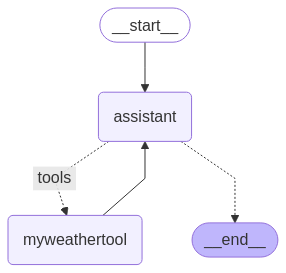

In [101]:
display(Image(app.get_graph().draw_mermaid_png()))

In [102]:
app.invoke({"messages": ["hi how are you"]})

{'messages': [HumanMessage(content='hi how are you', additional_kwargs={}, response_metadata={}, id='64e22958-b364-4b76-bb6c-8ca508c480f1'),
  AIMessage(content="I'm doing well, thanks for asking. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 216, 'total_tokens': 242, 'completion_time': 0.094545455, 'prompt_time': 0.014080699, 'queue_time': 0.057256330999999994, 'total_time': 0.108626154}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'stop', 'logprobs': None}, id='run-a428d07d-0f85-4e2a-9cc5-0eb570689a57-0', usage_metadata={'input_tokens': 216, 'output_tokens': 26, 'total_tokens': 242})]}

In [105]:
input = {"messages": ["what's the weather in Delhi"]}
app.invoke(input)

{'messages': [HumanMessage(content="what's the weather in Delhi", additional_kwargs={}, response_metadata={}, id='da22c10a-8203-4ef7-b1e9-eff5adf9ce14'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r1ph', 'function': {'arguments': '{"query": "Delhi weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 218, 'total_tokens': 233, 'completion_time': 0.054545455, 'prompt_time': 0.021619951, 'queue_time': 0.056309796999999995, 'total_time': 0.076165406}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d0415924-309a-4d7f-8c85-0165cca1ba53-0', tool_calls=[{'name': 'search', 'args': {'query': 'Delhi weather'}, 'id': 'call_r1ph', 'type': 'tool_call'}], usage_metadata={'input_tokens': 218, 'output_tokens': 15, 'total_tokens': 233}),
  ToolMessage(content='the weather is hotty with some foggy', name='search

In [104]:
input = {"messages": ["who is the first president of usa?"]}
app.invoke(input)

{'messages': [HumanMessage(content='who is the first president of usa?', additional_kwargs={}, response_metadata={}, id='75d8f310-4e8d-4d8f-b43e-2bd2dd9e03a5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6dhn', 'function': {'arguments': '{"query": "first president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 220, 'total_tokens': 236, 'completion_time': 0.058181818, 'prompt_time': 0.013436892, 'queue_time': 0.055744168000000004, 'total_time': 0.07161871}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f72bc46c-c93d-41dc-bcd0-22d213f43086-0', tool_calls=[{'name': 'search', 'args': {'query': 'first president of USA'}, 'id': 'call_6dhn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 220, 'output_tokens': 16, 'total_tokens': 236}),
  ToolMessage(content='weather is cloudy with some

In [106]:
for output in app.stream({"messages": ["What's the weather in delhi"]}):
    for key, value in output.items():
        print(f"here is output from {key}")
        print("____")
        print(value)
        print("\n")

here is output from assistant
____
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3fsb', 'function': {'arguments': '{"query": "delhi weather today"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 219, 'total_tokens': 235, 'completion_time': 0.058181818, 'prompt_time': 0.013370578, 'queue_time': 0.057142172, 'total_time': 0.071552396}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0b50e871-159e-4e11-8e42-5aad039a57f9-0', tool_calls=[{'name': 'search', 'args': {'query': 'delhi weather today'}, 'id': 'call_3fsb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 219, 'output_tokens': 16, 'total_tokens': 235})]}


here is output from myweathertool
____
{'messages': [ToolMessage(content='the weather is hotty with some foggy', name='search', id='e8bffc55-7d8e-4811-83e0-2f2641cf31cc', tool

In [108]:
@tool
def multiply(a:int, b:int) -> int:
    """multiply a and b"""
    return a*b

In [109]:
@tool 
def add(a:int, b:int) -> int:
    """add a and b"""
    return a+b

In [111]:
@tool 
def devide(a:int, b:int) -> int:
    """deviding two numbers a and b"""
    return a*b

In [112]:
@tool
def subtract(a:int, b:int) -> int:
    """Subtracting two numbers a and b"""
    return a - b

In [113]:
from langchain_community.tools import DuckDuckGoSearchResults, DuckDuckGoSearchRun

In [124]:
duck_search = DuckDuckGoSearchRun()

In [115]:
search.invoke("who is the president of usa?")

"The president of the United States is the: U.S. head of state; Chief executive of the federal government; Commander-in-Chief of the armed forces; Current president. The 47th and current president of the United States is Donald John Trump. He was sworn into office on January 20, 2025. Former U.S. presidents. The United States has had 46 former U ... WASHINGTON − Donald Trump was sworn in Monday as the 47th president of the United States, returning to the White House after overcoming four criminal indictments and two assassination attempts ... Donald Trump has officially become the 47th president of the United States. In a special ceremony called an inauguration , President Trump took over from Joe Biden as America's new leader. Donald Trump became the 47th president of the United States on January 20, 2025 (Credit: The Trump White House, Public Domain/ Wikimedia Commons) On January 20, 2025, Donald Trump was sworn in as the 47th President of the United States. He is only the second Pre

In [125]:
tools = [multiply, add, devide, subtract, duck_search]

In [126]:
llm_with_tools = llm.bind_tools(tools)

In [127]:
llm_with_tools.invoke("add 3 and 5")

AIMessage(content='<function=add{"a": 3, "b": 5}</function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 502, 'total_tokens': 520, 'completion_time': 0.065454545, 'prompt_time': 0.039957684, 'queue_time': 0.058589315999999995, 'total_time': 0.105412229}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run-8614c706-4251-4c55-898a-e7628859126b-0', usage_metadata={'input_tokens': 502, 'output_tokens': 18, 'total_tokens': 520})

In [128]:
llm_with_tools.invoke("hi").tool_calls

[]

In [129]:
llm_with_tools.invoke("add 3 and 5").tool_calls

[{'name': 'add',
  'args': {'a': 3, 'b': 5},
  'id': 'call_vt52',
  'type': 'tool_call'}]

In [130]:
llm_with_tools.invoke("can you multiply 3 and 5").tool_calls

[{'name': 'multiply',
  'args': {'a': 3, 'b': 5},
  'id': 'call_xj82',
  'type': 'tool_call'}]

In [131]:
llm_with_tools.invoke("what is the current gdp of india with current affairs").tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'current GDP of India'},
  'id': 'call_hsws',
  'type': 'tool_call'}]

In [132]:
from langchain_core.messages import HumanMessage, SystemMessage

In [133]:
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

In [176]:
def assistant(state:MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg]+state['messages'])]}

In [182]:
builder = StateGraph(MessagesState)

In [183]:
from langgraph.prebuilt import tools_condition

In [184]:
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_conditional_edges("assistant",
                              tools_condition
                              )

builder.add_edge(START, "assistant")
builder.add_edge("tools", "assistant")

react_app = builder.compile()

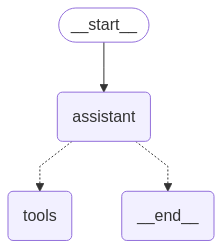

In [ ]:
display(Image(react_app.get_graph().draw_mermaid_png()))

In [181]:
message = [HumanMessage(content="what is twice of narendra modi's current age")]

In [185]:
response = react_app.invoke({"messages": message})

In [186]:
response

{'messages': [HumanMessage(content="what is twice of narendra modi's current age", additional_kwargs={}, response_metadata={}, id='bc0a3f2a-167a-4e7d-9d6d-88fff4ab130c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4hrs', 'function': {'arguments': '{"query": "Narendra Modi current age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}, {'id': 'call_s1c4', 'function': {'arguments': '{"a": 2, "b": 72}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 525, 'total_tokens': 565, 'completion_time': 0.145454545, 'prompt_time': 0.040503681, 'queue_time': 0.05333979900000001, 'total_time': 0.185958226}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9f49ed12-7ded-4d27-bac2-be940acf1a60-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Narendra Modi current age'}, 'id': 'call_4hrs', 'type':

In [187]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is twice of narendra modi's current age
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_4hrs)
 Call ID: call_4hrs
  Args:
    query: Narendra Modi current age
  multiply (call_s1c4)
 Call ID: call_s1c4
  Args:
    a: 2
    b: 72
================================= Tool Message =================================
Name: duckduckgo_search

Prime Minister Narendra Modi Biography: Discover Narendra Modi's Age, Full Name, Family, Salary, Date of Birth, Qualification, Net Worth, Mother's Name, and Age. ... In Vadnagar, Mehsana district, Bombay State (current-day Gujarat), Narendra Damodardas Modi in 1950, to a Gujarati Hindu family of grocery store owners. PM Modi birthday is ... Narendra Modi (born September 17, 1950, Vadnagar, India) is an Indian politician and government official who rose to become a senior leader of the Bharatiya Janata 

In [188]:
message = [HumanMessage(content="hi hello how are you")]

In [189]:
response = react_app.invoke({"messages": message})

In [190]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

hi hello how are you
================================== Ai Message ==================================

I'm doing well, thank you for asking. Is there something I can help you with, such as answering a question or performing a calculation?


In [191]:
message = [HumanMessage(content="what is current gdp of china and india can you give me difference between them?")]

response = react_app.invoke({"messages": message})

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is current gdp of china and india can you give me difference between them?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_yhte)
 Call ID: call_yhte
  Args:
    query: current GDP of China and India
  duckduckgo_search (call_h674)
 Call ID: call_h674
  Args:
    query: current GDP of China
  duckduckgo_search (call_5vd3)
 Call ID: call_5vd3
  Args:
    query: current GDP of India
================================= Tool Message =================================
Name: duckduckgo_search

Error: DuckDuckGoSearchException(RatelimitException('https://html.duckduckgo.com/html 202 Ratelimit'))
 Please fix your mistakes.
================================= Tool Message =================================
Name: duckduckgo_search

Error: DuckDuckGoSearchException(RatelimitException('https://lite.duckduckgo.com/lite/ 202 Ratelimit'))
 Please fix y